In [143]:
# Importing Packages
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO
from imitation.algorithms.adversarial.airl import AIRL
from imitation.util import util
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.rewards.reward_nets import RewardNet
from imitation.util.networks import RunningNorm
from imitation.util import networks, util
import matplotlib.pyplot as plt
import pandas as pd
import torch as th
import torch.nn as nn
import torch.nn.init as init
from mpl_toolkits.mplot3d import Axes3D

In [144]:
SEED = 42
np.random.seed(SEED)
th.manual_seed(SEED)
if th.cuda.is_available():
    th.cuda.manual_seed_all(SEED)

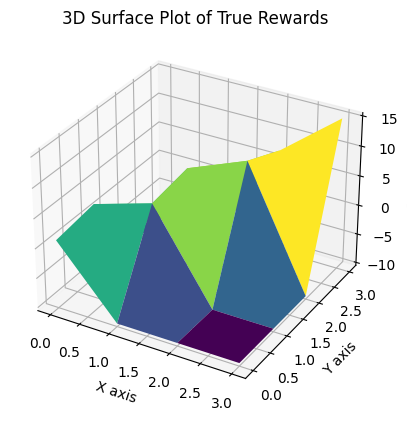

In [145]:
true_rewards = np.array([
    [1, -10, -10, -10],
    [2, 5, -10, -10],
    [-10, 6, 10, -10],
    [-10, -10, 7, 15]
])

grid_size = 4

# Generate grid for 3D plot
X = np.linspace(0, grid_size-1, grid_size)
Y = np.linspace(0, grid_size-1, grid_size)
gridx, gridy = np.meshgrid(X, Y)

# Create 3D Surface Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gridx, gridy, true_rewards, cmap="viridis")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Reward")
ax.set_title("3D Surface Plot of True Rewards")

plt.show()

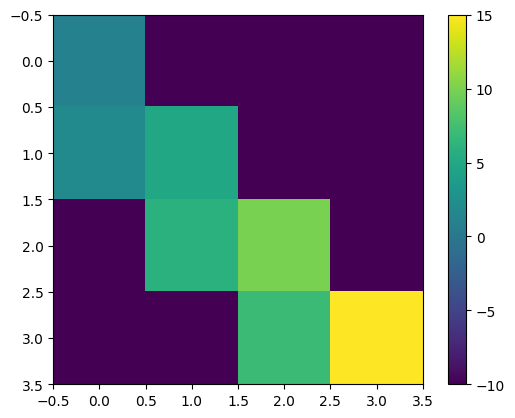

In [146]:
plt.imshow(true_rewards, interpolation='nearest')
plt.colorbar()

In [147]:
num_grids = grid_size ** 2
num_directions = 4

In [183]:
class GameEnv(gym.Env):
    def __init__(self):
        self.height = 4
        self.width = 4
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=max(self.height, self.width)-1, shape=(2,), dtype=np.int32)

        self.moves = {
            0: (-1, 0),   # up
            1: (0, 1),    # right
            2: (1, 0),    # down
            3: (0, -1)    # left
        }

        # Define rewards for each cell in the grid
        self.true_rewards = np.array([
            [0, -1, -1, -1],
            [-1, 0, -1, 0],
            [-1, -1, -1, -1],
            [-1, -1, -1, 10]
        ])

        # Begin in start state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)
        # Start position in the grid
        self.S = (0, 0)
        return np.array(self.S, dtype=np.int32)  # Return as 1D vector

    def step(self, action):
        # Calculate new position based on the action
        dx, dy = self.moves[action]
        self.S = (self.S[0] + dx, self.S[1] + dy)

        # Enforce grid boundaries
        self.S = (max(0, min(self.S[0], self.height - 1)),
                  max(0, min(self.S[1], self.width - 1)))

        # Calculate reward based on new position
        reward = self.true_rewards[self.S]

        # Check if goal (bottom-right corner) is reached
        done = self.S == (self.height - 1, self.width - 1)

        # Return observation as 1D vector, reward, done, truncated (False), and empty info dictionary
        return np.array(self.S, dtype=np.int32), reward, done, False, {}

    def render(self, mode='human'):
        # Optional: Implement visualization here if desired
        pass


In [184]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
env = DummyVecEnv([lambda: GameEnv()])


In [186]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import adversarial
from imitation.data import rollout
from imitation.util import util

# Step 2: Collect expert demonstrations using a trained PPO agent
expert = PPO("MlpPolicy", env, verbose=1)
expert.learn(total_timesteps=2000)
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_episodes=60),
    rng=np.random.default_rng(SEED),
)

learner = PPO(
    env=env,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0005,
    gamma=0.95,
    clip_range=0.1,
    vf_coef=0.1,
    n_epochs=5,
    seed=SEED,
)
reward_net = BasicShapedRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
    normalize_input_layer=RunningNorm,
)
airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=2048,
    gen_replay_buffer_capacity=512,
    n_disc_updates_per_round=16,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net,
)


# Step 4: Plot the learned reward across the grid
# Create a mesh of the learned rewards by querying the learned reward function
rewards_grid = np.zeros((4, 4))
for row in range(4):
    for col in range(4):
        obs = np.array([row, col], dtype=np.int32)
        obs = obs.reshape(1, -1)  # Reshape for compatibility
        rewards_grid[row, col] = airl_trainer.reward_net.predict(obs)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5207 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------


KeyError: 'rollout'

In [177]:
# Initialize AIRL and train on expert data
airl_trainer = adversarial.AIRL(
    venv=env,
    expert_data=rollouts,
    gen_algo=PPO("MlpPolicy", env, verbose=1),
)
airl_trainer.train(total_timesteps=2000)

# Plot the learned reward function
rewards_grid = np.zeros((env.envs[0].height, env.envs[0].width))
for row in range(env.envs[0].height):
    for col in range(env.envs[0].width):
        obs = np.array([row, col], dtype=np.int32).reshape(1, -1)
        rewards_grid[row, col] = airl_trainer.reward_net.predict(obs)

# Display the learned reward as a heatmap
plt.imshow(rewards_grid, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Learned Reward")
plt.title("Learned Reward Function (AIRL)")
plt.xlabel("Grid Width")
plt.ylabel("Grid Height")
plt.xticks(range(env.envs[0].width))
plt.yticks(range(env.envs[0].height))
plt.show()

AttributeError: module 'imitation.algorithms.adversarial' has no attribute 'AIRL'